In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
from src.regime_trading_pipeline import RegimeRotationStrategy, StrategyResult
from src.constants import CLUSTER_PALETTE


def show_results(result: StrategyResult):
    print("Start date:", result.metrics["start_date"])
    print("End date:  ", result.metrics["end_date"])
    print("Duration:  ", (pd.to_datetime(result.metrics["end_date"]) - pd.to_datetime(result.metrics["start_date"])).days, "\n")
    for i, cnt in enumerate(np.bincount(result.signal_series)):
        print("# of points in cluster", i, ":", cnt)

    df_list = [result.metrics]
    for item in result.benchmarks:
        df_list.append(RegimeRotationStrategy._compute_metrics(result.benchmarks[item].pct_change()))
    df = pd.DataFrame(df_list, index=["Strategy"] + list(result.benchmarks.keys()))
    df = df.drop(columns=["start_date", "end_date", "duration"])
    return df


def plot_results(result: StrategyResult, type: str):
    def max_drawdown_span(curve: pd.Series) -> tuple[pd.Timestamp, pd.Timestamp]:
        roll_max = curve.cummax()
        drawdown = curve / roll_max - 1
        trough = drawdown.idxmin()
        peak = curve.loc[:trough].idxmax()
        return peak, trough
    peak, trough = max_drawdown_span(result.equity_curve)

    _, (ax_equity, ax_weight) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (3, 1)})

    # top panel: equity curves
    ax_equity.plot(result.equity_curve.index, result.equity_curve, label="Strategy", zorder=100, color=CLUSTER_PALETTE[0])
    ax_equity.axvspan(peak, trough, color="red", alpha=0.15, label="Max DD")
    cols = ["gray", "darkgray", "lightgray", CLUSTER_PALETTE[2]]
    for i, (k, v) in enumerate(result.benchmarks.items()):
        ax_equity.plot(v.index, v, label=k, color=cols[i], zorder=-i)
    ax_equity.set_title(f"Equity Curve ({type})")
    ax_equity.grid(alpha=0.6)
    ax_equity.legend()

    # bottom panel: signal/weight series
    ax_weight.plot(result.weights.index, result.signal_series, color=CLUSTER_PALETTE[1], lw=1)
    ax_weight.set_ylabel("Regimes")
    ax_weight.set_xlabel("Date")
    ax_weight.grid(alpha=0.6)

    plt.tight_layout()
    plt.show()

In [2]:
growth = [
    "ADBE", "CRM", "LULU", "ORLY", "COST",
    "TMO", "LIN", "ACN", "MA", "V",
    "SPGI", "MCO", "DHR", "SHW", "INTU",
    "NFLX", "NOW", "SNPS", "ISRG", "CDNS",
]

# Retrieved from https://www.simplysafedividends.com/world-of-dividends/posts/939-20-best-recession-proof-dividend-stocks-for-a-2025-downturn
defensive = [
    "EPD", "VZ", "O", "GIS", "BMY",
    "KMB", "CVX", "PSA", "PEP", "XOM",
    "DUK", "ED", "GPC", "WEC", "LMT",
    "KO", "PG", "JNJ", "CL", "MCD",
]

strategy = RegimeRotationStrategy(
    growth_tickers=growth,
    defensive_tickers=defensive,
    start_date="2019-05-09",  # 5 yrs data (post covid)
    p_dim=2,                  # W2 distance
    window=360,               # approx. 15 days hourly return
    step=12,                  # half a day
    refit_every=48,           # refit MK-means every 24 days
    shift=True                # avoid using future information
)

strategy.fit_kmeans()
strategy.build_returns()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 666
# of points in cluster 1 : 352
# of points in cluster 2 : 238


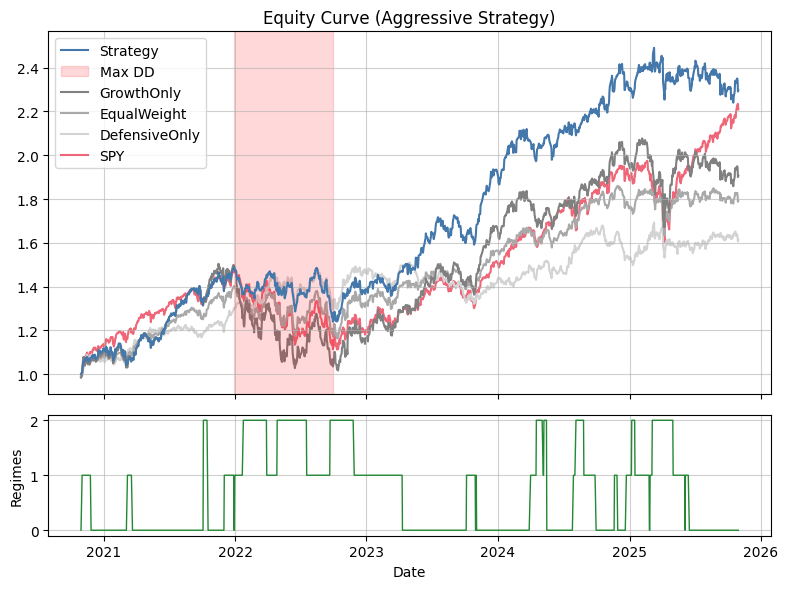

,cumulative_return,annual_return,annual_volatility,sharpe,max_drawdown
Strategy,1.297386,0.181617,0.150980,1.202922,-0.167134
GrowthOnly,0.937040,0.141854,0.207817,0.682590,-0.324234
EqualWeight,0.809958,0.126413,0.140871,0.897372,-0.170234
DefensiveOnly,0.615923,0.101075,0.121813,0.829759,-0.125564
SPY,1.233195,0.174918,0.171519,1.019820,-0.244964


In [3]:
result = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.5, "defensive": 0.5},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

df = show_results(result)
plot_results(result, "Aggressive Strategy")
df

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 666
# of points in cluster 1 : 352
# of points in cluster 2 : 238


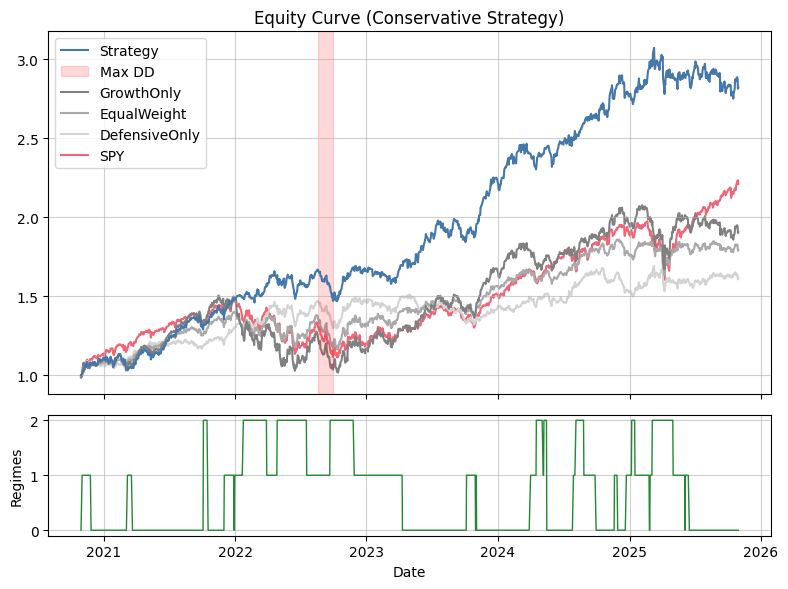

,cumulative_return,annual_return,annual_volatility,sharpe,max_drawdown
Strategy,1.822319,0.231426,0.146641,1.578175,-0.119491
GrowthOnly,0.937040,0.141854,0.207817,0.682590,-0.324234
EqualWeight,0.809958,0.126413,0.140871,0.897372,-0.170234
DefensiveOnly,0.615923,0.101075,0.121813,0.829759,-0.125564
SPY,1.233195,0.174918,0.171519,1.019820,-0.244964


In [4]:
result = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.0, "defensive": 1.0},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

df = show_results(result)
plot_results(result, "Conservative Strategy")
df

In [5]:
df = RegimeRotationStrategy.grid_search_regimes(
    growth,
    defensive,
    start_date="2019-05-09",
    windows=(36, 72, 120, 240, 360, 480),
    steps=(6, 12, 24, 48),
    refits=(12, 24, 48, 96, 120),
)
df

Output()

start_date    end_date  duration  \
p window step refit_every burn_in                                     
2 360    12   48          700      2020-10-30  2025-10-30      1826   
              120         700      2020-10-30  2025-10-30      1826   
              24          700      2020-10-30  2025-10-30      1826   
              96          700      2020-10-30  2025-10-30      1826   
  480    12   96          700      2020-11-06  2025-10-30      1819   
...                                       ...         ...       ...   
  360    48   120         700      2025-02-05  2025-10-30       267   
              96          700      2025-02-05  2025-10-30       267   
              48          700      2025-02-05  2025-10-30       267   
              24          700      2025-02-05  2025-10-30       267   
              12          700      2025-02-05  2025-10-30       267   

                                   cumulative_return  annual_return  \
p window step refit_every burn_in                                     
2 360    12   48          700               1.822319       0.231426   
              120         700               1.790998       0.228672   
              24          700               1.765278       0.226391   
              96          700               1.762518       0.226146   
  480    12   96          700               1.562750       0.208730   
...                                              ...            ...   
  360    48   120         700              -0.226053      -0.293322   
              96          700              -0.226053      -0.293322   
              48          700              -0.226053      -0.293322   
              24          700              -0.226053      -0.293322   
              12          700              -0.226053      -0.293322   

                                   annual_volatility    sharpe  max_drawdown  
p window step refit_every burn_in                                             
2 360    12   48          700               0.146641  1.578175     -0.119491  
              120         700               0.146571  1.560147     -0.119491  
              24          700               0.147363  1.536279     -0.119491  
              96          700               0.147225  1.536051     -0.119491  
  480    12   96          700               0.146796  1.421901     -0.128024  
...                                              ...       ...           ...  
  360    48   120         700               0.173418 -1.691418     -0.245345  
              96          700               0.173418 -1.691418     -0.245345  
              48          700               0.173418 -1.691418     -0.245345  
              24          700               0.173418 -1.691418     -0.245345  
              12          700               0.173418 -1.691418     -0.245345  

[120 rows x 8 columns]